# Sound Source Localization - Demonstration

## Project Definition
Build MLP and CNN network for Sound Source Localization.

## Project Details
* Input: binaural audio files, output: labels
* Classify 3 azimuth angles using binaural audio files as inputs. The azimuth angles are: 0, 30, and 60 degrees
* Use MFCC as input features
* Metrics: classification accuracy


## The link to the dataset:

bit.ly/ssl_demo


## The Process:
 <ol>
  <li>Mount google drive to acquire datset</li>
  <li>Locate data and copy it to google colab</li>
  <li>Import libraries</li>
  <li>Load data</li>
  <li>Build Neural Network</li>
  <li>Train model</li>
  <li>Test model</li>
  <li>Evaluate model</li>
</ol> 




## 1. Mount google drive

In [ ]:
# Mount Google Drive to get dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Link to dataset
bit.ly/ssl_demo

## 2. Locate data and copy it to google colab

In [ ]:
# This will take approximately 1 minutes

!cp '/content/drive/My Drive/ssl_demo_personal/ssl_dataset.zip' .
!unzip -q ssl_dataset.zip

cp: cannot stat '/content/drive/My Drive/ssl_demo_personal/ssl_dataset.zip': No such file or directory
unzip:  cannot find or open ssl_dataset.zip, ssl_dataset.zip.zip or ssl_dataset.zip.ZIP.


## 3. Import libraries

In [ ]:
!pip install python_speech_features

  Created wheel for python-speech-features: filename=python_speech_features-0.6-cp36-none-any.whl size=5887 sha256=c2cbc04ac75b265045b0f36d7687eb79e01f0a50f361e130bde8d0c28d6e8aed
  Stored in directory: /root/.cache/pip/wheels/3c/42/7c/f60e9d1b40015cd69b213ad90f7c18a9264cd745b9888134be
Successfully built python-speech-features


In [ ]:
!pip install tqdm

In [ ]:
import os
import pickle
import keras
import pickle
import numpy as np
import pandas as pd
import seaborn as sn
import tensorflow as tf
import matplotlib.pyplot as plt

from tqdm import tqdm
from scipy.io import wavfile
from python_speech_features import mfcc
from sklearn.metrics import accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight

from keras import optimizers
from keras import regularizers
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM, GRU, Dropout, Dense, TimeDistributed, Bidirectional
from keras.models import Sequential, load_model
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint

## 4. Load data



### 4.A. Build helper function to load data

In [ ]:
# Data pickling and saving
class Config:
    def __init__(self, mode='conv', nfilt=26, nfeat=13, nfft=2048, rate=44100):
        self.mode = mode
        self.nfilt = nfilt
        self.nfeat = nfeat
        self.nfft = nfft
        self.rate = rate
        self.step = int(rate/10)
        self.model_path = os.path.join('models',mode + '.model')
        self.p_path = os.path.join('pickles', mode + '.p')

In [ ]:
# Check whether the data already loaded
def check_data():
    if os.path.isfile(config.p_path):
        print('Loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None

In [ ]:
# Load data array, convert it to MFCC, and save it to pickle file
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        
        # Load data
        rate, wav = wavfile.read('train_files/'+file) 
        label = df.at[file, 'label']
        #print(f"Number of Channels = {wav.shape[1]}")

        # Sample data
        rand_index = np.random.randint(0, wav.shape[0]-config.step)  #random index for sampling start point      
        sample = wav[rand_index:rand_index+config.step] #sampling end after 0.1 second or 4410 index 

        # Convert to MFCC
        X_sample = mfcc(sample, rate,numcep=config.nfeat, nfilt=config.nfilt,
                        nfft=config.nfft) #Noted that in here the ata is tranformed into MFCC type

        # Scale data
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        
        # Put data into an array
        X.append(X_sample)
        y.append(classes.index(label))
    
    config.min = _min
    config.max = _max

    # Convert to numpy array
    X, y = np.array(X), np.array(y)
    X = (X - _min) / (_max - _min)
    
    # Resize data according to its mode
    if config.mode == 'conv':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2], 1)
    elif config.mode == 'mlp':
        X = X.reshape(X.shape[0], X.shape[1], X.shape[2])
    
    y = to_categorical(y, num_classes = 3)
    config.data = (X, y)
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol=2)
    
    return X, y

### 4.B. Visualize data distribution

In [ ]:
# Get file names of the training set
df = pd.read_csv('/content/train_sound.csv')
df.set_index('fname', inplace=True)

# Read the file based on the file names we have acquired
for f in df.index:
    rate, signal = wavfile.read('train_files/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate

classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()
 
prob_dist = class_dist / class_dist.sum()
choices = np.random.choice(class_dist.index, p=prob_dist)

In [ ]:
#We sample through 0.1 s of each audio, 
#We use the factor 2 to avoid moving exactly after 0.1s to the next 0.1s directly 
#Instead, take a 0.05s step forward and then sample the next 0.1s from that point
#It means that the second half of the last sample becomes the first half 
#of the next sample. E.g; first sample time range: 0.1s to 0.2s, 
#second sample time range: 0.15s to 0.25s
n_samples = 2 * int(df['length'].sum()/0.1) 

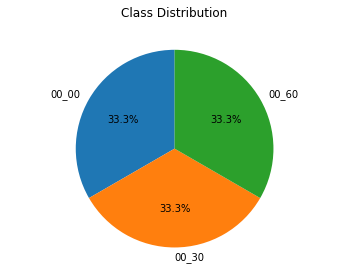

In [ ]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

## 5. Build Neural Network Model

### 5.A. Convolutional Neural Networks

In [ ]:
# Build CNN Model
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(64, (3,3), activation='relu', strides=(1,1), 
                     padding='same'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))
    model.add(Conv2D(32, (3,3), activation='relu', strides=(1,1), 
                     padding='same'))
    model.add(MaxPool2D(2,2))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(3, activation='softmax'))
    #model.summary()
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.001), 
                  metrics=['acc'] )
    return model

### 5.B. Multi Layer Perceptron (MLP)

In [ ]:
# Build MLP model 
def get_mlp_model():
    model = Sequential()
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=keras.optimizers.Adam(lr=0.0015), 
                  metrics=['acc'] )
    return model

## 6. Train the model

### 6.A. Define which architecture to use

In [ ]:
# Define neural network type
config = Config(mode='conv')

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2], 1)
    model = get_conv_model()
    
elif config.mode == 'mlp':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1) #return the index value
    input_shape = (X.shape[1], X.shape[2])
    model = get_mlp_model()

100%|██████████| 10800/10800 [00:50<00:00, 213.41it/s]


### 6.B. Run the training

In [ ]:
# Estimate class weights for unbalanced datasets.
class_weight = compute_class_weight('balanced', 
                                    np.unique(y_flat),
                                    y_flat)

# Save if accuracy increase
checkpoint = ModelCheckpoint(config.model_path, monitor='val_acc', verbose=1, mode='max',
                             save_best_only=True, save_weights_only=False, period=1)

# Run the model training
history = model.fit(X, y, epochs=10, batch_size=64, 
          shuffle=True, validation_split=0.1, # Use 10% of the training set as validation set
          callbacks = [checkpoint])

Epoch 1/10
151/152 [============================>.] - ETA: 0s - loss: 0.8019 - acc: 0.6595
Epoch 00001: val_acc improved from -inf to 0.97593, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets
152/152 [==============================] - 6s 38ms/step - loss: 0.7990 - acc: 0.6611 - val_loss: 0.2807 - val_acc: 0.9759
Epoch 2/10
151/152 [============================>.] - ETA: 0s - loss: 0.1885 - acc: 0.9560
Epoch 00002: val_acc improved from 0.97593 to 0.98611, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets
152/152 [==============================] - 6s 39ms/step - loss: 0.1886 - acc: 0.9558 - val_loss: 0.0820 - val_acc: 0.9861
Epoch 3/10
151/152 [============================>.] - ETA: 0s - loss: 0.0878 - acc: 0.9801
Epoch 00003: val_acc improved from 0.98611 to 0.99722, saving model to models/conv.model
INFO:tensorflow:Assets written to: models/conv.model/assets
152/152 [==============================

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 19, 13, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 6, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 9, 6, 64)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 6, 32)          18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 4, 3, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 3, 32)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)              

### 6.C. Plot training and validation accuracy

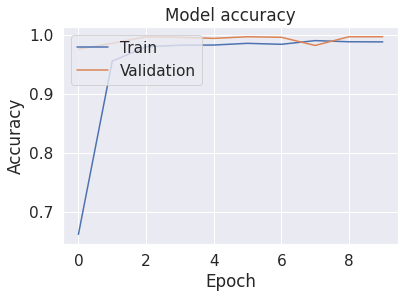

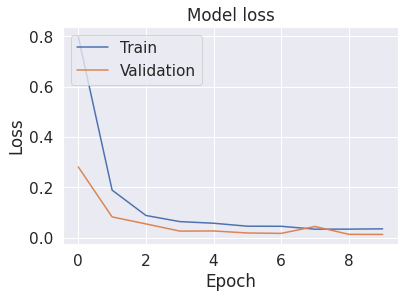

INFO:tensorflow:Assets written to: models/conv.model/assets


In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

model.save(config.model_path)

## 7. Test our model

In [ ]:
def build_predictions(audio_dir):
    y_true = []
    y_pred = []
    fn_prob = {}
    
    print('Extracting features from audio')
    for fn in tqdm(os.listdir(audio_dir)):
        rate, wav = wavfile.read(os.path.join(audio_dir, fn))
        label = fn2class[fn]
        c = classes.index(label)
        y_prob = []
        
        for i in range(0,wav.shape[0]-config.step, config.step):
            sample = wav[i:i+config.step]
            X =  mfcc(sample, rate,numcep=config.nfeat, 
                      nfilt=config.nfilt, nfft=config.nfft)
            X = (X - config.min)/(config.max - config.min)
            
            if config.mode == 'conv':
                X = X.reshape(1, X.shape[0], X.shape[1], 1)
            elif config.mode == 'mlp':
                X = np.expand_dims(X, axis=0)
            y_hat = model.predict(X)
            y_prob.append(y_hat)
            y_pred.append(np.argmax(y_hat))
            y_true.append(c)
            
        fn_prob[fn] = np.mean(y_prob, axis=0).flatten()
    
    return y_true, y_pred, fn_prob

In [ ]:
# Load test csv
df = pd.read_csv('test_sound.csv')

# Define available class
classes = list(np.unique(df.label))

# Dictionary of file name and its label
fn2class = dict(zip(df.fname, df.label))

# Define pickle path
p_path = os.path.join('pickles','conv.p')

# Load pickle
with open(p_path, 'rb') as handle:
    config = pickle.load(handle)

# Load model
model = load_model(config.model_path)

In [ ]:
# Predict score
y_true, y_pred, fn_prob = build_predictions('test_files/') 

# Calculate accuracy score
acc_score = accuracy_score(y_true=y_true, y_pred=y_pred)
print(acc_score)

  0%|          | 0/90 [00:00<?, ?it/s]

Extracting features from audio


100%|██████████| 90/90 [00:32<00:00,  2.74it/s]

0.9938271604938271


In [ ]:
print(acc_score)

0.9938271604938271


## 8. Evaluation

### 8.A. Precision, Recall, F-1

In [ ]:
print(classification_report(y_true, y_pred, target_names=classes))

              precision    recall  f1-score   support

       00_00       1.00      0.98      0.99       270
       00_30       0.98      1.00      0.99       270
       00_60       1.00      1.00      1.00       270

    accuracy                           0.99       810
   macro avg       0.99      0.99      0.99       810
weighted avg       0.99      0.99      0.99       810



### 8.B. Confusion Matrix

In [ ]:
con_mat = tf.math.confusion_matrix(labels=y_true,predictions=y_pred)

In [ ]:
# Print confusion matrix
print('Confusion Matrix: \n\n', con_mat)

Confusion Matrix: 

 tf.Tensor(
[[265   5   0]
 [  0 270   0]
 [  0   0 270]], shape=(3, 3), dtype=int32)


In [ ]:
# Change to numpy
a = con_mat.numpy()

# Normalize convolution matrix
a_norm = np.around(a.astype('float') / a.sum(axis=1)[:, np.newaxis], decimals=2)

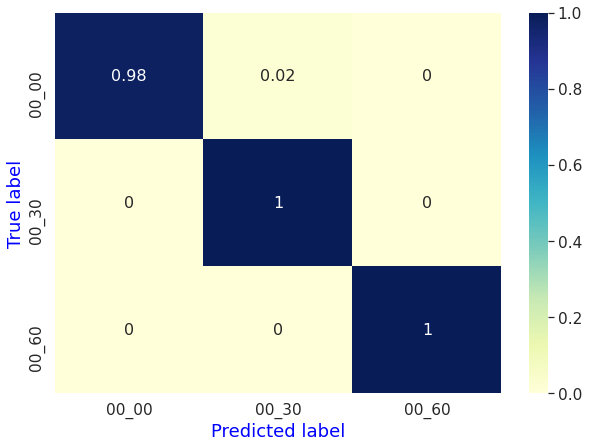

In [ ]:
# Draw confusion matrix

df_cm = pd.DataFrame(a_norm, index = [i for i in classes],
                  columns = [i for i in classes])

plt.figure(figsize = (10,7))
sn.set(font_scale=1.4) 
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap="YlGnBu")

plt.ylabel('True label', fontsize=18, color="blue")
plt.xlabel('Predicted label', fontsize=18, color="blue")
plt.show()

# End of Project

## Sources:
* https://github.com/seth814/Audio-Classification
* https://github.com/arief25ramadhan/Sound-Source-Localization